In [222]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math

In [223]:
# Load in the data
data_day = pd.read_csv('day.csv')
data_hour = pd.read_csv('hour.csv')

In [224]:
# Set what evening means
evening_hrs = np.arange(15, 23)

# set what is spring and summer
season = {'winter': 1,
          'spring': 2,
          'summer': 3,
          'autumn': 4}

In [225]:
# create df only looking at evening hours, and their respective season
data_spring_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['spring']) &
                                (data_hour['workingday']==1)]
data_summer_workday = data_hour[(data_hour['hr'].isin(evening_hrs)) &
                                (data_hour['season']==season['summer']) &
                                (data_hour['workingday']==1)]

# now summarise the data so each line in data represents one samle event, ie. the total number of bike hires 
# during peak commuting times on a single day
data_spring_eve_workday = data_spring_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()
data_summer_eve_workday = data_summer_workday.groupby(['dteday', 'weekday'])[['casual', 'registered', 'cnt']].sum()

# get the weather, temp and hum info average for the evening on that day
data_spring_eve_workday_weather = data_spring_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()
data_summer_eve_workday_weather = data_summer_workday.groupby(['dteday', 'weekday'])[['weathersit', 'temp', 'atemp', 'weathersit', 'hum', 'windspeed']].mean()

# join average weather data to bike counts
data_spring_eve_workday = pd.concat([data_spring_eve_workday, data_spring_eve_workday_weather], axis=1)
data_summer_eve_workday = pd.concat([data_summer_eve_workday, data_summer_eve_workday_weather], axis=1)

In [226]:
# Quick sense check on the size of the new data sets
# number of working days in data_day should be the same as number of rows in summer_eve + spring_eve

print(f"spring shape: {data_spring_eve_workday.shape}")
print(f"summer shape: {data_summer_eve_workday.shape}")
print(f"total spring and summer working day shape: {data_day[(data_day['workingday']==True) & (data_day['season'].isin([2,3]))].shape}")

# check the average weather data for one day
"""
selected_day = '2012-06-14'
data_day[(data_day['dteday']==selected_day)]
data_hour[(data_hour['dteday']==selected_day) &
          data_hour['hr'].isin(evening_hrs)]
data_summer_eve_workday[data_summer_eve_workday['dteday']==selected_day]
"""

spring shape: (128, 9)
summer shape: (131, 9)
total spring and summer working day shape: (259, 16)


"\nselected_day = '2012-06-14'\ndata_day[(data_day['dteday']==selected_day)]\ndata_hour[(data_hour['dteday']==selected_day) &\n          data_hour['hr'].isin(evening_hrs)]\ndata_summer_eve_workday[data_summer_eve_workday['dteday']==selected_day]\n"

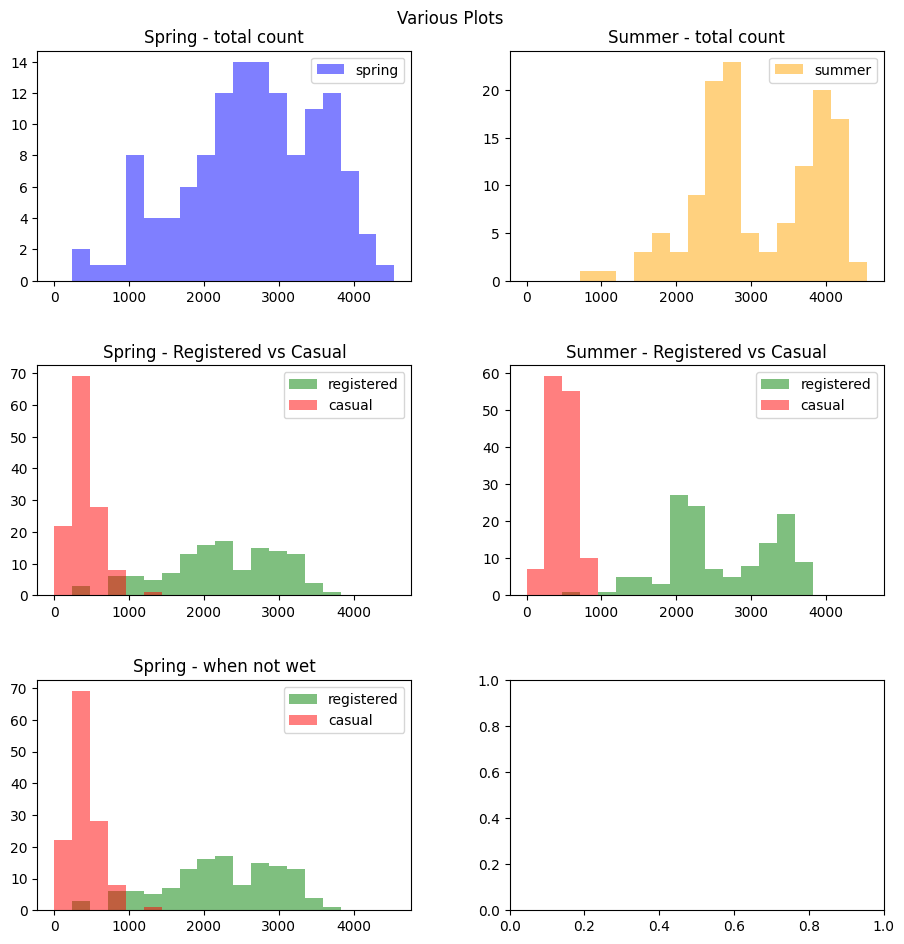

In [227]:
# setup axes
fig, axs = plt.subplots(3,2, figsize=(10,10))
fig.tight_layout(pad=4)
fig.suptitle('Various Plots')

# histogram paramaters
n_bins = 20
x_min = 0
x_max = max(data_spring_eve_workday['cnt'].max(), data_summer_eve_workday['cnt'].max())
bins = np.linspace(x_min, x_max, n_bins)

# total count spring (evening, workday)
axs[0,0].hist(x='cnt', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='blue', label='spring')
axs[0,0].legend()
axs[0,0].title.set_text('Spring - total count')

# total count summer (evening, workday)
axs[0,1].hist(x='cnt', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='orange', label='summer')
axs[0,1].legend()
axs[0,1].title.set_text('Summer - total count')

#  Spring - registered users vs casual
axs[1,0].hist(x='registered', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,0].hist(x='casual', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,0].legend()
axs[1,0].title.set_text('Spring - Registered vs Casual')

# summer - registered users vs casual
axs[1,1].hist(x='registered', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[1,1].hist(x='casual', data=data_summer_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[1,1].legend()
axs[1,1].title.set_text('Summer - Registered vs Casual')

#  Spring - when not wet
axs[2,0].hist(x='registered', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='green', label='registered')
axs[2,0].hist(x='casual', data=data_spring_eve_workday, bins=bins, alpha=0.5, color='red', label='casual')
axs[2,0].legend()
axs[2,0].title.set_text('Spring - when not wet')

In [228]:
data_hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [229]:
# Imperical cdf - data is a df, x is a scaler, 
def empircal_cdf(x, data, index, col):
    sum = data.loc[data[index] <= x, col].sum()
    return sum / data[col].sum()

In [230]:
data_spring_eve_workday.sort_values(by=['cnt'])

,,casual,registered,cnt,weathersit,temp,atemp,weathersit,hum,windspeed
dteday,weekday,,,,,,,,,
2011-04-22,5,50,361,411,3.000,0.3200,0.310575,3.000,0.91625,0.190300
2011-03-30,3,43,431,474,2.625,0.2575,0.248113,2.625,0.90750,0.235075
2011-04-08,5,54,462,516,2.500,0.3125,0.291650,2.500,0.92250,0.285438
2011-03-31,4,76,745,821,2.375,0.2925,0.282187,2.375,0.89250,0.222000
2012-06-01,5,134,875,1009,3.000,0.6575,0.602275,3.000,0.78750,0.292900
...,...,...,...,...,...,...,...,...,...,...
2012-06-14,4,698,3347,4045,1.125,0.6950,0.643962,1.125,0.54000,0.236937
2012-05-31,4,630,3452,4082,1.000,0.7200,0.649637,1.000,0.37375,0.199638
2012-06-07,4,583,3519,4102,1.000,0.6825,0.636362,1.000,0.36125,0.229488


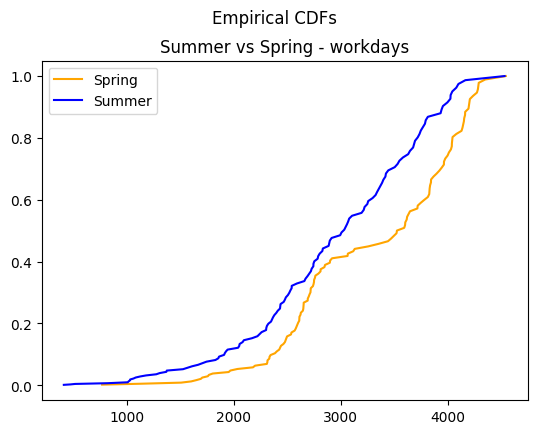

In [231]:
# Plot cdfs of found Gaussians:
fig, axs = plt.subplots(1)
fig.tight_layout(pad=4)
fig.suptitle('Empirical CDFs')

# Calculate Spring CDF
sorted_spring_data = data_spring_eve_workday.sort_values(by=['cnt'])
ecdf_spring_eve_workday = np.zeros(sorted_spring_data.shape[0])
for i, day in enumerate(sorted_spring_data['cnt']):
    ecdf_spring_eve_workday[i] = empircal_cdf(day, sorted_spring_data, 'cnt', 'cnt')

# Calculate Summer CDF
sorted_summer_data = data_summer_eve_workday.sort_values(by=['cnt'])
ecdf_summer_eve_workday = np.zeros(sorted_summer_data.shape[0])
for i, day in enumerate(sorted_summer_data['cnt']):
    ecdf_summer_eve_workday[i] = empircal_cdf(day, sorted_summer_data, 'cnt', 'cnt')

# Plot Spring vs Summer cdf
axs.plot(sorted_summer_data['cnt'], ecdf_summer_eve_workday, color = 'orange', label='Spring')
axs.plot(sorted_spring_data['cnt'], ecdf_spring_eve_workday, color = 'blue', label='Summer')
axs.title.set_text("Summer vs Spring - workdays")
axs.legend()